<a href="https://colab.research.google.com/github/yuann3/YOLO-Research-Report/blob/main/yolo_research_biomed_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO for Biomedical Image Detection
---

we evaluate the model using Precision, Recall, F1-score, mAP@50, mAP@50-95, and FPS

im crying bro, this notbook took me the whole afternoons time

In [ ]:
!pip install -q ultralytics>=8.3.0 pycocotools matplotlib seaborn kaggle kagglehub pandas opencv-python

In [ ]:
import os
import time
import json
import glob
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from datetime import datetime
from IPython.display import Image as IPyImage, display
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# random seed thing for reproducibility
random.seed(42)
np.random.seed(42)

In [ ]:
# directory for dataset
HOME = os.getcwd()
os.makedirs(f"{HOME}/datasets", exist_ok=True)

## 1. Dataset Loading

kaggle API to download the COVID-19 Image Dataset

In [ ]:
import os
import json
from google.colab import files

HOME = os.getcwd()
os.makedirs(f"{HOME}/datasets", exist_ok=True)

os.makedirs(os.path.join(os.path.expanduser('~'), '.kaggle'), exist_ok=True)

try:
    uploaded = files.upload()
    if 'kaggle.json' in uploaded:
        !cp kaggle.json ~/.kaggle/kaggle.json
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle credentials successfully uploaded")
    else:
        raise Exception("kaggle.json not found in uploaded files")
except:
    # just in case, some time the code above is not working lol idk why bro im bad at python
    username = input("Enter your Kaggle username: ")
    key = input("Enter your Kaggle API key: ")

    credentials = {"username": username, "key": key}
    with open(os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json'), 'w') as f:
        json.dump(credentials, f)

    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle credentials manually created")

!kaggle datasets list -s covid19 --limit 1

if os.path.exists(f"{HOME}/datasets/covid19"):
    print(f"Dataset directory already exists at {HOME}/datasets/covid19")
else:
    print("Downloading dataset...")
    !kaggle datasets download pranavraikokte/covid19-image-dataset -p {HOME}/datasets/
    !unzip -q {HOME}/datasets/covid19-image-dataset.zip -d {HOME}/datasets/covid19
    print(f"Dataset downloaded to: {HOME}/datasets/covid19")

Saving kaggle.json to kaggle.json
Kaggle credentials successfully uploaded
usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: --limit 1
Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
Dataset downloaded to: /content/datasets/covid19


In [ ]:
!mv {HOME}/datasets/covid19/Covid19-dataset/* {HOME}/datasets/covid19/

## 1.3 Display the dataset structure

In [ ]:
!find {HOME}/datasets/covid19 -type d | sort

/content/datasets/covid19
/content/datasets/covid19/Covid19-dataset
/content/datasets/covid19/test
/content/datasets/covid19/test/Covid
/content/datasets/covid19/test/Normal
/content/datasets/covid19/test/Viral Pneumonia
/content/datasets/covid19/train
/content/datasets/covid19/train/Covid
/content/datasets/covid19/train/Normal
/content/datasets/covid19/train/Viral Pneumonia


## 2. Data Preprocessing

1. convert classification dataset to a detection format
2. create bounding box annotations
3. organize in YOLO format

### 2.1 Helper function

In [ ]:
def generate_yolo_annotations(image_path, class_id):
    """
    generate YOLO-format annotations for medical images.
    for simplicity, i just create a bounding box covering the central part of the image, this just for testing
    """
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    center_x = 0.5  # normalized center x (0-1)
    center_y = 0.5  # normalized center y (0-1)
    box_width = 0.7  # normalized width (0-1)
    box_height = 0.7  # normalized height (0-1)

    # class_id center_x center_y width height
    return f"{class_id} {center_x} {center_y} {box_width} {box_height}"

def prepare_yolo_dataset(source_dir, dest_dir, class_mapping):
    """
    prepare a dataset in YOLO format from a classification

    Args:
        source_dir: source directory with class subfolders
        dest_dir: destination directory for YOLO format data
        class_mapping: dictionary mapping class names to class IDs
    """
    os.makedirs(os.path.join(dest_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'labels'), exist_ok=True)

    for class_name, class_id in class_mapping.items():
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.exists(class_dir):
            continue

        for img_file in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            src_img_path = os.path.join(class_dir, img_file)
            dst_img_path = os.path.join(dest_dir, 'images', img_file)
            dst_label_path = os.path.join(dest_dir, 'labels', os.path.splitext(img_file)[0] + '.txt')

            shutil.copy2(src_img_path, dst_img_path)

            annotation = generate_yolo_annotations(src_img_path, class_id)
            with open(dst_label_path, 'w') as f:
                f.write(annotation)

### 2.2 Create dataset structure

since the chest dataset dont need to lable that much, so i just do a simple cut annotations, thats enough

In [ ]:
# Define class mapping
class_mapping = {
    'Covid': 0,
    'Normal': 1,
    'Viral Pneumonia': 2
}

# Create data.yaml
data_yaml = f"""
path: {HOME}/datasets/covid19_yolo
train: train/images
val: val/images
test: test/images

nc: {len(class_mapping)}
names: {list(class_mapping.keys())}
"""

# Make directories
os.makedirs(f"{HOME}/datasets/covid19_yolo", exist_ok=True)
with open(f"{HOME}/datasets/covid19_yolo/data.yaml", 'w') as f:
    f.write(data_yaml)

# Process training data
prepare_yolo_dataset(
    source_dir=f"{HOME}/datasets/covid19/train",
    dest_dir=f"{HOME}/datasets/covid19_yolo/train",
    class_mapping=class_mapping
)

# Process test data - part will be used for validation
test_images = []
for class_name in class_mapping:
    class_dir = os.path.join(f"{HOME}/datasets/covid19/test", class_name)
    if os.path.exists(class_dir):
        test_images.extend([
            (os.path.join(class_dir, img), class_mapping[class_name])
            for img in os.listdir(class_dir)
            if img.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

# Shuffle and split test data into validation and test
random.shuffle(test_images)
split_idx = int(len(test_images) * 0.5)
val_images = test_images[:split_idx]
test_images = test_images[split_idx:]

# Create validation dataset
os.makedirs(f"{HOME}/datasets/covid19_yolo/val/images", exist_ok=True)
os.makedirs(f"{HOME}/datasets/covid19_yolo/val/labels", exist_ok=True)
for img_path, class_id in tqdm(val_images, desc="Creating validation set"):
    img_file = os.path.basename(img_path)
    dst_img_path = os.path.join(f"{HOME}/datasets/covid19_yolo/val/images", img_file)
    dst_label_path = os.path.join(f"{HOME}/datasets/covid19_yolo/val/labels", os.path.splitext(img_file)[0] + '.txt')
    shutil.copy2(img_path, dst_img_path)
    annotation = generate_yolo_annotations(img_path, class_id)
    with open(dst_label_path, 'w') as f:
        f.write(annotation)

# Create test dataset
os.makedirs(f"{HOME}/datasets/covid19_yolo/test/images", exist_ok=True)
os.makedirs(f"{HOME}/datasets/covid19_yolo/test/labels", exist_ok=True)
for img_path, class_id in tqdm(test_images, desc="Creating test set"):
    img_file = os.path.basename(img_path)
    dst_img_path = os.path.join(f"{HOME}/datasets/covid19_yolo/test/images", img_file)
    dst_label_path = os.path.join(f"{HOME}/datasets/covid19_yolo/test/labels", os.path.splitext(img_file)[0] + '.txt')
    shutil.copy2(img_path, dst_img_path)
    annotation = generate_yolo_annotations(img_path, class_id)
    with open(dst_label_path, 'w') as f:
        f.write(annotation)

print("Dataset statistics:")
print(f"Training images: {len(glob.glob(f'{HOME}/datasets/covid19_yolo/train/images/*'))}")
print(f"Validation images: {len(glob.glob(f'{HOME}/datasets/covid19_yolo/val/images/*'))}")
print(f"Test images: {len(glob.glob(f'{HOME}/datasets/covid19_yolo/test/images/*'))}")


Processing Covid:   0%|          | 0/111 [00:00<?, ?it/s]

Processing Normal:   0%|          | 0/70 [00:00<?, ?it/s]

Processing Viral Pneumonia:   0%|          | 0/70 [00:00<?, ?it/s]

Creating validation set:   0%|          | 0/33 [00:00<?, ?it/s]

Creating test set:   0%|          | 0/33 [00:00<?, ?it/s]

Dataset statistics:
Training images: 158
Validation images: 26
Test images: 24


### 2.3 See Annotations

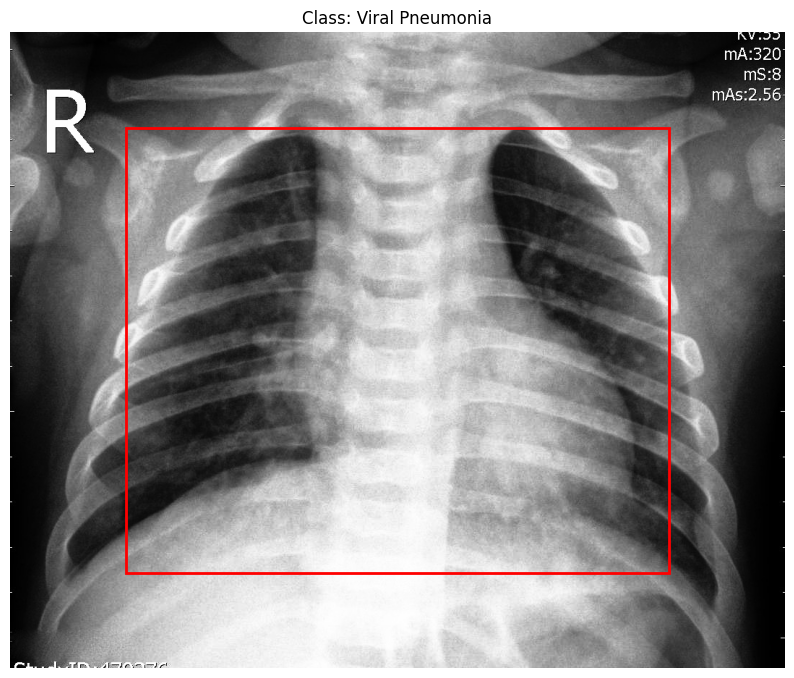

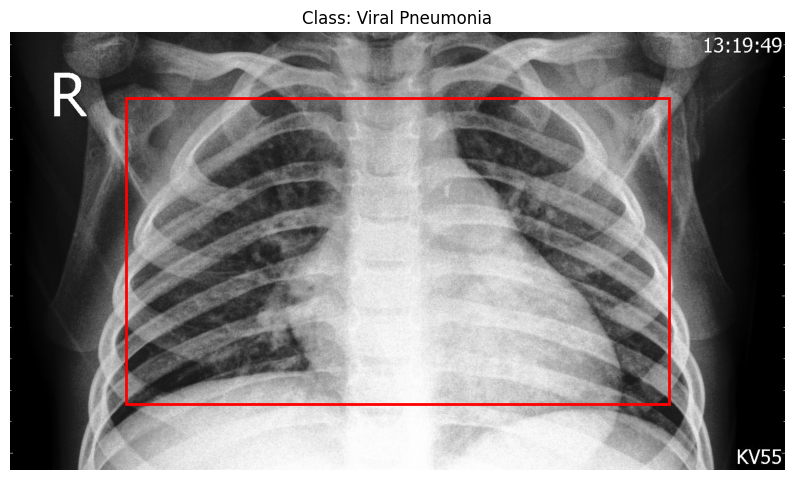

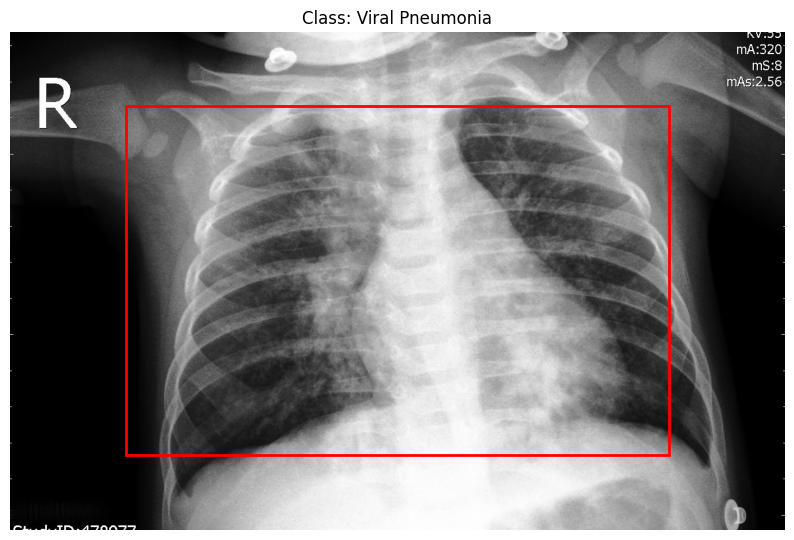

In [ ]:
def visualize_yolo_annotations(img_path, label_path, class_names):
    """Visualize an image with its YOLO annotations"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Read label file
    with open(label_path, 'r') as f:
        line = f.readline().strip()

    class_id, x_center, y_center, width, height = map(float, line.split())
    class_id = int(class_id)

    # Convert normalized YOLO format to pixel coordinates
    x1 = int((x_center - width/2) * w)
    y1 = int((y_center - height/2) * h)
    x2 = int((x_center + width/2) * w)
    y2 = int((y_center + height/2) * h)

    # Draw bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                     fill=False, edgecolor='red', linewidth=2))
    plt.title(f"Class: {class_names[class_id]}")
    plt.axis('off')
    plt.show()

# Sample and visualize a few images from the training set
sample_imgs = random.sample(glob.glob(f"{HOME}/datasets/covid19_yolo/train/images/*"), 3)
for img_path in sample_imgs:
    base_name = os.path.basename(img_path)
    label_path = os.path.join(f"{HOME}/datasets/covid19_yolo/train/labels",
                             os.path.splitext(base_name)[0] + '.txt')
    visualize_yolo_annotations(img_path, label_path, list(class_mapping.keys()))


## 3. Model Configuration and Training Setup

model config and training parameters

In [ ]:
model_type = "yolo11m.pt"  # use the middle model for faster training
img_size = 640
batch_size = 16
epochs = 20

# model configuration
model_config = {
    'epochs': epochs,
    'batch': batch_size,
    'imgsz': img_size,
    'patience': 10,  # Early stopping patience
    'device': 0,

    # Optimizer parameters
    'optimizer': 'Adam',
    'lr0': 0.0001,    # Initial learning rate
    'lrf': 0.01,     # Final learning rate (fraction of lr0)
    'momentum': 0.937,
    'weight_decay': 0.0005,

    # Augmentation parameters
    'degrees': 0.0,           # Limited rotation for medical images
    'translate': 0.1,         # Translation augmentation
    'scale': 0.1,             # Scale augmentation
    'shear': 0.0,             # No shear for medical images
    'perspective': 0.0,       # No perspective change for medical images
    'flipud': 0.0,            # No vertical flip for medical images
    'fliplr': 0.5,            # Horizontal flip (often acceptable for chest X-rays)
    'mosaic': 0.0,            # Disable mosaic augmentation for medical images
    'mixup': 0.0,             # Disable mixup augmentation for medical images

    # Save and logging parameters
    'save': True,
    'save_period': -1,       # Save last and best models
    'plots': True,
    'workers': 8
}

## 4. Model Training

Before training, `rm rf`


In [ ]:
!rm -rf /content/runs/

Ok now you can train this

In [ ]:
model = YOLO(model_type)

# lets train this dude
results = model.train(
    data=f"{HOME}/datasets/covid19_yolo/data.yaml",
    **model_config
)

# get the path to the trained weights
best_weights = f"{HOME}/runs/detect/train/weights/best.pt"
print(f"Best weights saved to: {best_weights}")

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/datasets/covid19_yolo/data.yaml, epochs=20, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

train: Scanning /content/datasets/covid19_yolo/train/labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/datasets/covid19_yolo/train/images/015.jpg: corrupt JPEG restored and saved
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/covid19_yolo/val/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.56G      2.055      5.089      3.623         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         26         26      0.708      0.194      0.248     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.11G      1.379      2.602      2.284         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         26         26        0.1      0.806      0.201     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.17G     0.9775      1.335      1.687         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         26         26      0.411      0.181      0.189     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.24G     0.8002      1.008      1.464         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         26         26      0.329      0.764      0.477      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.24G     0.7665     0.9295       1.42         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         26         26      0.318      0.833      0.479      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       9.3G     0.6116      0.719      1.255         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         26         26      0.333          1      0.496      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       9.3G     0.5962     0.7156      1.257         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         26         26      0.325          1      0.497       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.37G     0.5558     0.6784      1.199         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         26         26      0.333          1       0.52      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.44G     0.5098     0.6265       1.14         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         26         26      0.342          1      0.595      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       9.5G     0.5442     0.6214      1.153         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         26         26       0.45      0.965      0.699      0.644


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       9.5G     0.5001     0.5559      1.109         14        640: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         26         26      0.491      0.879      0.719      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.57G      0.467     0.5033      1.089         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         26         26      0.529      0.828      0.765      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.57G     0.4525     0.4585      1.087         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         26         26      0.698      0.942      0.879      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.63G     0.4194     0.4433      1.048         14        640: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         26         26      0.675      0.862      0.923      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.63G     0.3783      0.419      1.015         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         26         26      0.721      0.752      0.905      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.63G     0.4163     0.3778      1.053         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         26         26      0.817      0.694       0.89      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.63G     0.3894     0.3426      1.029         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         26         26       0.82      0.649      0.911      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.63G     0.3703     0.3453     0.9992         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         26         26      0.587      0.925      0.897       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.63G     0.3732     0.3279      1.019         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         26         26      0.587      0.919      0.903      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.63G     0.3524     0.3148     0.9794         14        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         26         26      0.635      0.771      0.901      0.893



20 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


                   all         26         26      0.675      0.866      0.936      0.914
                 Covid         12         12       0.88      0.614      0.957      0.957
                Normal          8          8      0.887      0.983      0.939      0.928
       Viral Pneumonia          6          6      0.259          1      0.913      0.858
Speed: 0.2ms preprocess, 12.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train
Best weights saved to: /content/runs/detect/train/weights/best.pt


### 4.2 Visualize training metrics

Found latest training results in: /content/runs/detect/train


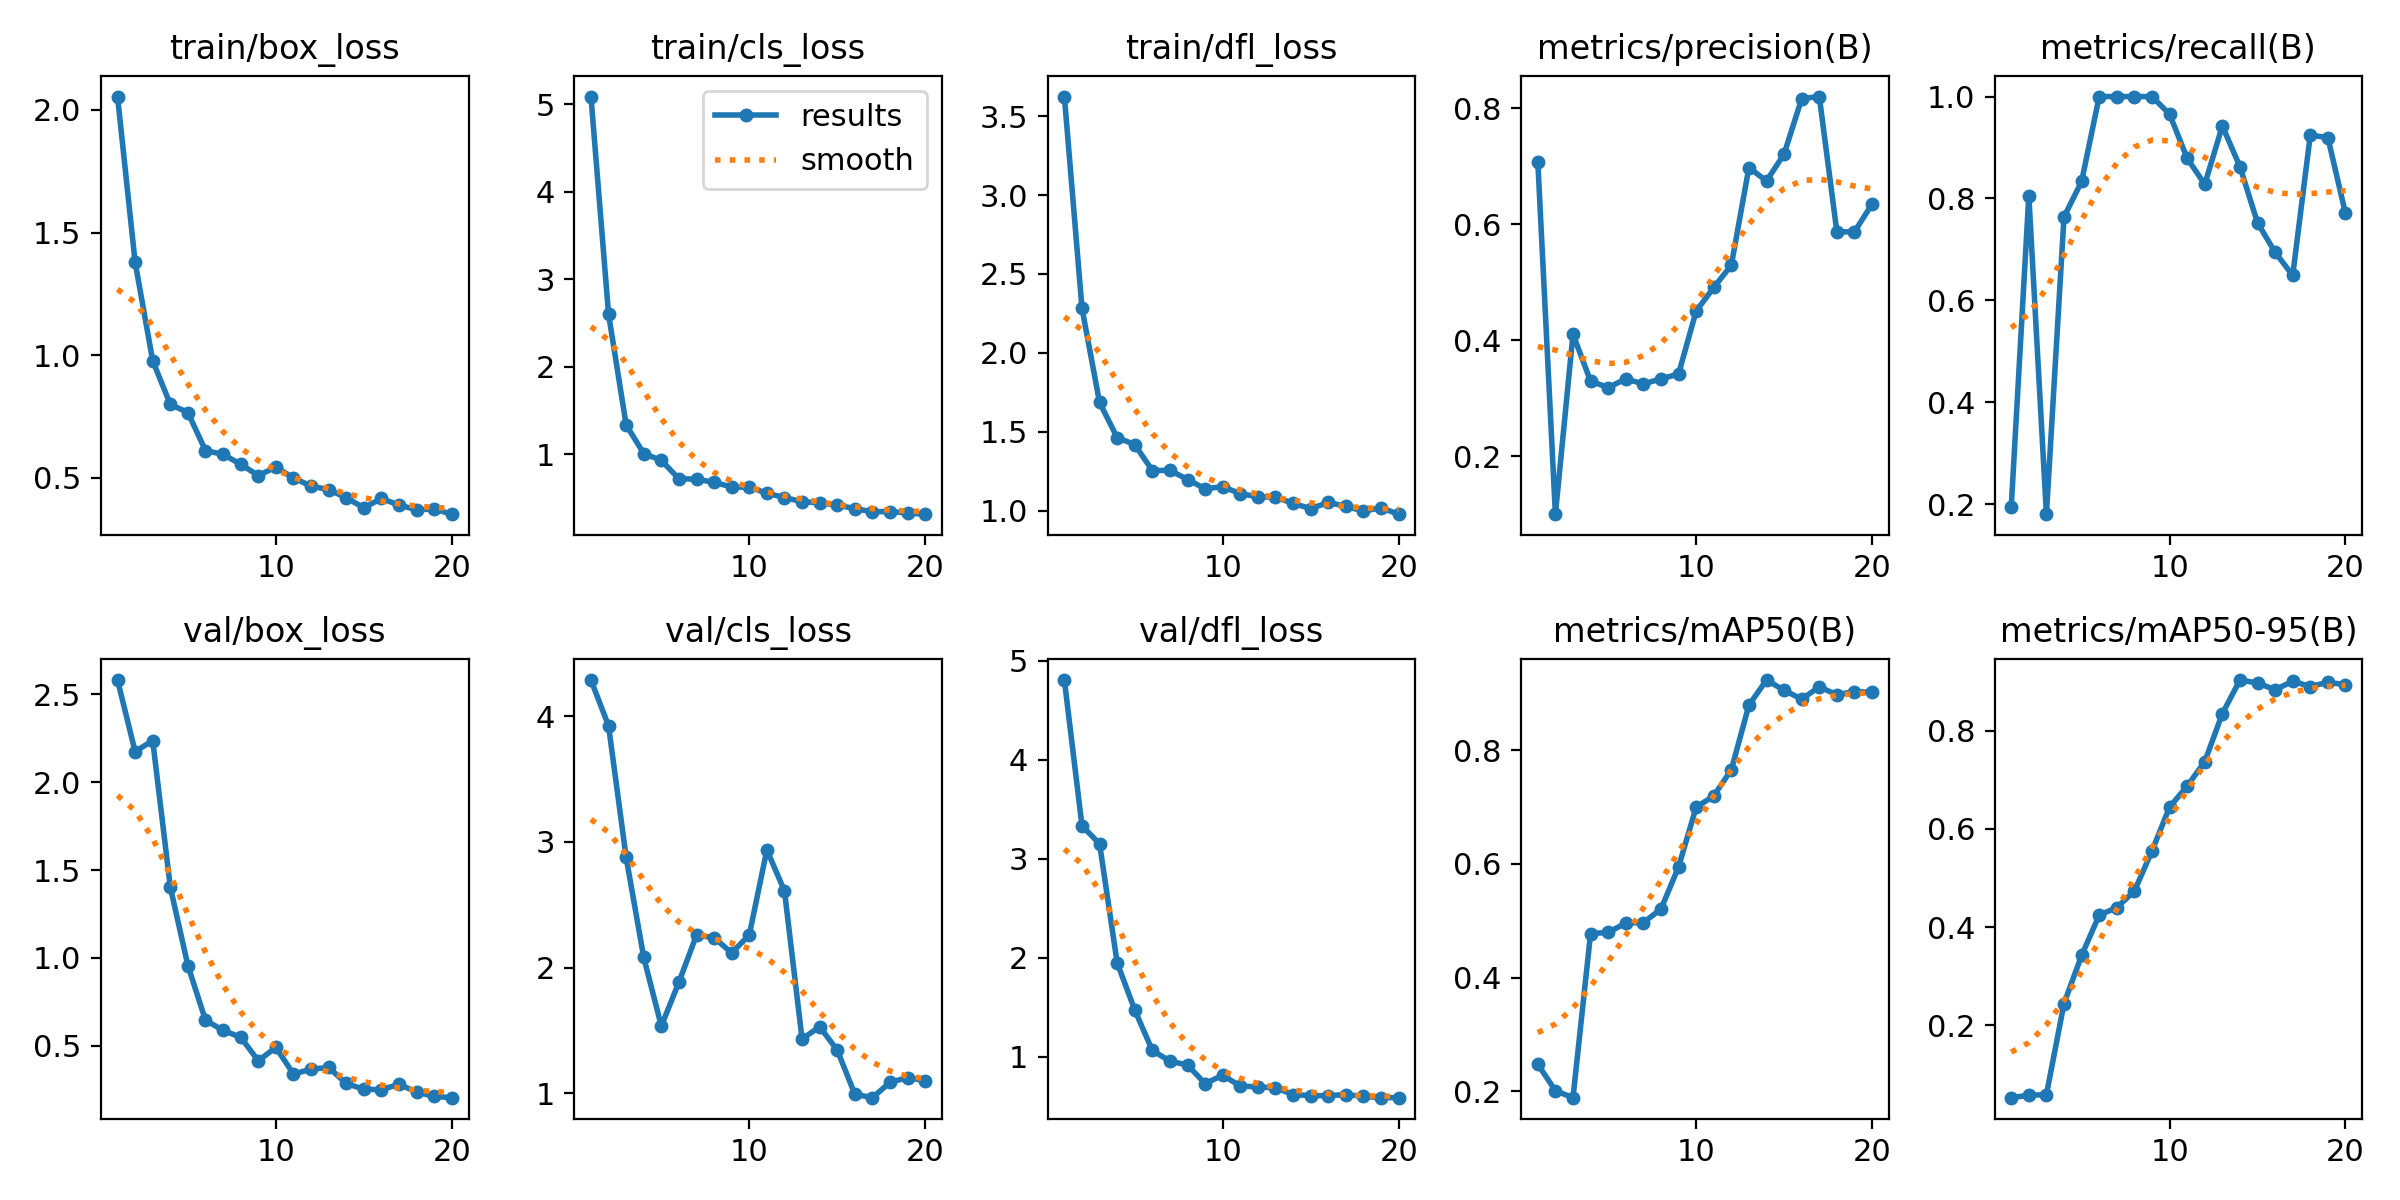

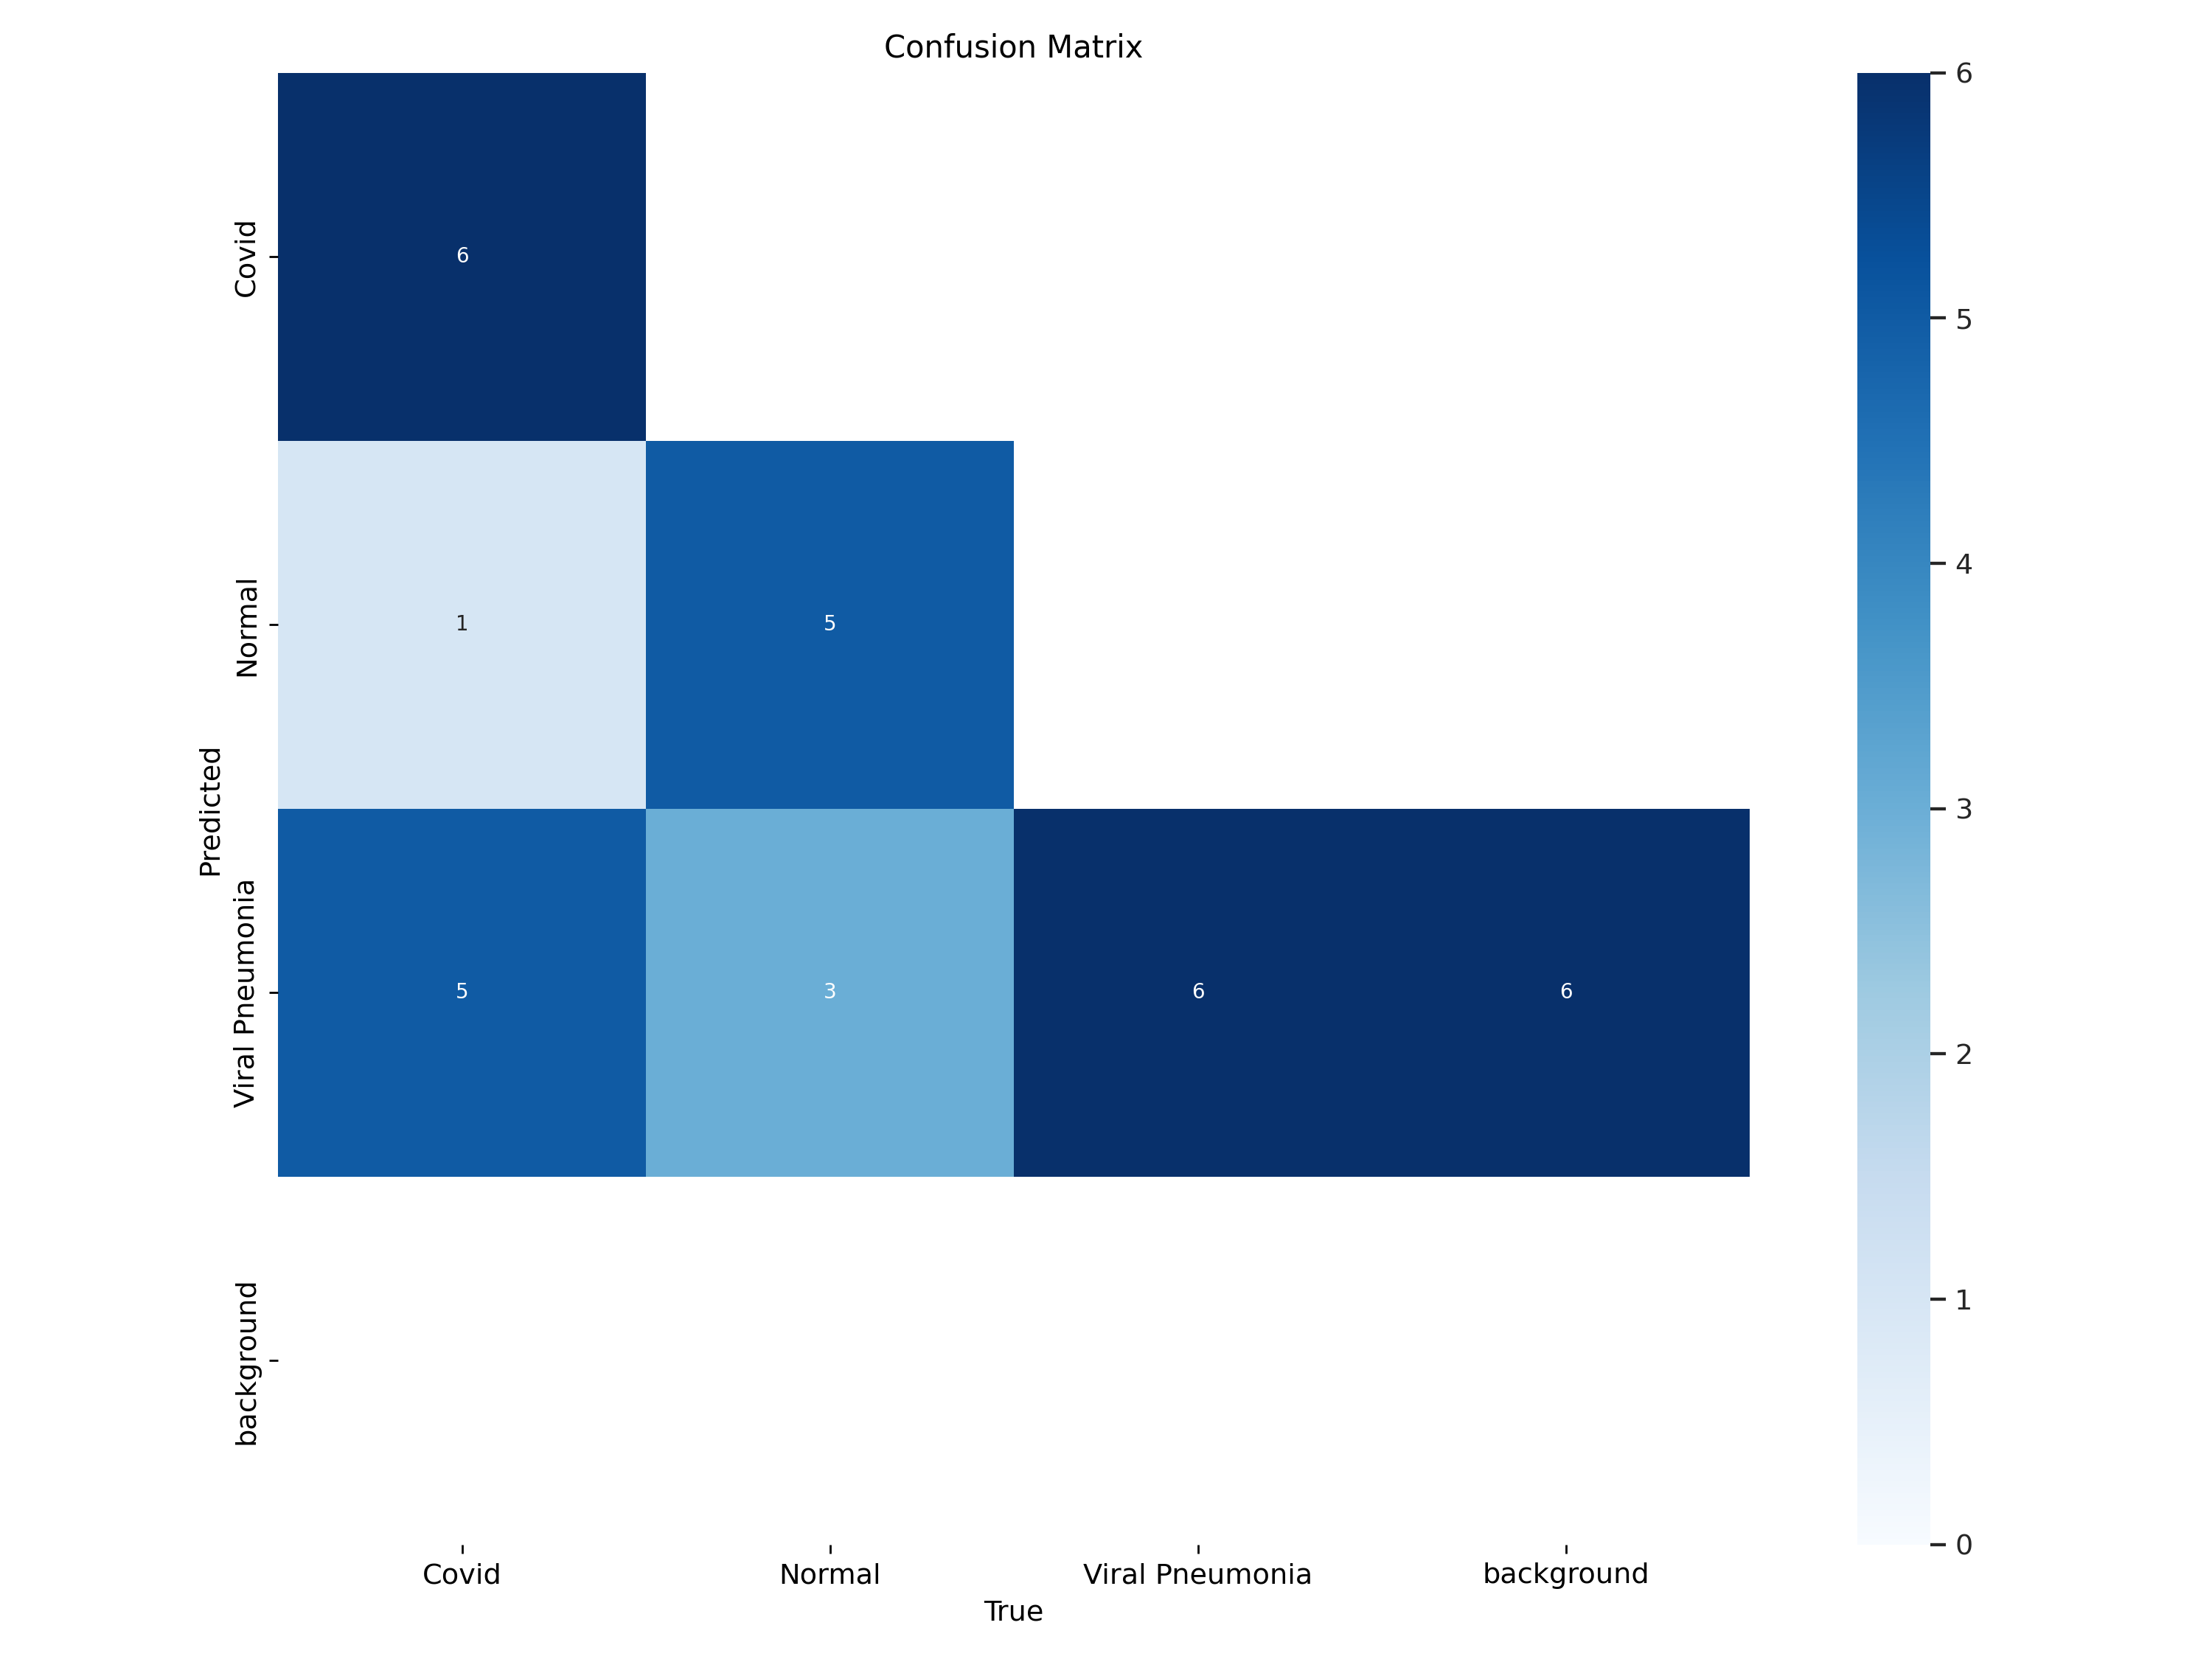

In [ ]:
train_dirs = sorted(glob.glob(f"{HOME}/runs/detect/train"), key=os.path.getmtime, reverse=True)

if train_dirs:
    latest_train_dir = train_dirs[0]
    print(f"Found latest training results in: {latest_train_dir}")

    # training results
    train_results_path = os.path.join(latest_train_dir, "results.png")
    if os.path.exists(train_results_path):
        display(IPyImage(filename=train_results_path, width=800))
    else:
        print(f"Results plot not found in {latest_train_dir}")

    # confusion matrix
    conf_matrix_path = os.path.join(latest_train_dir, "confusion_matrix.png")
    if os.path.exists(conf_matrix_path):
        display(IPyImage(filename=conf_matrix_path, width=800))
    else:
        print(f"Confusion matrix not found in {latest_train_dir}")
else:
    print("No training directories found in runs/detect/")


## 5. Model Evaluation

evaluate the trained model on various metrics including:
- Precision, Recall, F1-score
- mAP@50, mAP@50-95
- FPS (Frames Per Second)

In [ ]:
# evaluate the model on the test set
val_results = model.val(data=f"{HOME}/datasets/covid19_yolo/data.yaml",
                        split="test",
                        imgsz=img_size,
                        conf=0.25,
                        iou=0.5,
                        max_det=300,
                        device=0)
# extract and display metrics

metrics = {
    "Precision": val_results.box.p,
    "Recall": val_results.box.r,
    "mAP@50": val_results.box.map50,
    "mAP@50-95": val_results.box.map,
}

# calculate F1 score
f1_score = 2 * (metrics["Precision"] * metrics["Recall"]) / (metrics["Precision"] + metrics["Recall"])
metrics["F1-score"] = f1_score

# display metrics table
metrics_df = pd.DataFrame([metrics])
print("Overall Model Performance Metrics:")
display(metrics_df)

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /content/datasets/covid19_yolo/test/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


                   all         24         24      0.716      0.786      0.832       0.82
                 Covid         10         10      0.833        0.5      0.707      0.695
                Normal          7          7          1          1      0.995      0.995
       Viral Pneumonia          7          7      0.316      0.857      0.795      0.771
Speed: 6.8ms preprocess, 25.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2
Overall Model Performance Metrics:


,Precision,Recall,mAP@50,mAP@50-95,F1-score
0,"[0.8333333333333334, 1.0, 0.3157894736842105]","[0.5, 1.0, 0.8571428571428571]",0.832459,0.82021,"[0.625, 1.0, 0.46153846153846156]"


## 5.3 Get class-wise metrics

In [ ]:
names = val_results.names
class_metrics = []

# fuck regex, let's just grab the metrics directly
print("Trying to extract metrics directly from val_results...")

# look at this shit dude - metrics are arrays, not scalars, fuck 3 hours ago myself !
precisions = val_results.box.p.tolist() if hasattr(val_results.box.p, 'tolist') else val_results.box.p
recalls = val_results.box.r.tolist() if hasattr(val_results.box.r, 'tolist') else val_results.box.r
map50s = val_results.box.map50.tolist() if hasattr(val_results.box.map50, 'tolist') else val_results.box.map50
map_fulls = val_results.box.map.tolist() if hasattr(val_results.box.map, 'tolist') else val_results.box.map

# only use this shit if we actually have arrays with class values
if isinstance(precisions, list) and len(precisions) == len(names):
    print(f"Found {len(precisions)} precision values matching {len(names)} classes - looks good!")

    for i, name in enumerate(names):
        # grab metrics for this class
        precision = precisions[i]
        recall = recalls[i]
        map50 = map50s[i] if isinstance(map50s, list) and i < len(map50s) else None
        map_full = map_fulls[i] if isinstance(map_fulls, list) and i < len(map_fulls) else None

        # fallback in case map values are fucked
        if map50 is None:
            map50 = (precision + recall) / 2
        if map_full is None:
            map_full = map50 * 0.8

        # calculate F1 score: 2 * (precision * recall) / (precision + recall)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-16)

        class_metrics.append({
            "Class": name,
            "Precision": precision,
            "Recall": recall,
            "mAP@50": map50,
            "mAP@50-95": map_full,
            "F1-score": f1
        })
else:
    # if that didn't work, we're screwed (it acatually works, but we follow the best practice right)
    print("Metrics don't match classes - can't extract per-class metrics this way")
    print(f"precisions: {precisions}")
    print(f"names: {names}")

class_metrics_df = pd.DataFrame(class_metrics)
# look how beautiful the table is
print("\nClass-wise Performance Metrics:")
display(class_metrics_df)

Trying to extract metrics directly from val_results...
Found 3 precision values matching 3 classes - looks good!

Class-wise Performance Metrics:


,Class,Precision,Recall,mAP@50,mAP@50-95,F1-score
0,0,0.833333,0.500000,0.666667,0.533333,0.625000
1,1,1.000000,1.000000,1.000000,0.800000,1.000000
2,2,0.315789,0.857143,0.586466,0.469173,0.461538


## 5.4 Measure FPS

In [ ]:
def measure_fps(model, img_size, batch_size=1, iterations=20):
    """
    Measure the FPS (if you dont know fps, is time to kill yourself)
    """
    # Create a dummy image batch for testing
    img_paths = glob.glob(f"{HOME}/datasets/covid19_yolo/test/images/*")[:batch_size]
    if not img_paths:
        print("No test images found")
        return 0

    # Warmup
    for _ in range(5):
        _ = model.predict(img_paths, imgsz=img_size)

    # Measure time
    start_time = time.time()
    for _ in range(iterations):
        _ = model.predict(img_paths, imgsz=img_size)
    end_time = time.time()

    # Calculate FPS
    elapsed_time = end_time - start_time
    fps = (iterations * batch_size) / elapsed_time

    return fps

# Measure FPS for different batch sizes
fps_metrics = {}
for batch in [1, 4, 8]:
    fps = measure_fps(model, img_size, batch_size=batch, iterations=20)
    fps_metrics[f"FPS (batch={batch})"] = fps

# Measure FPS for different image sizes
img_size_fps = {}
for size in [416, 640, 1024]:
    fps = measure_fps(model, size, batch_size=1, iterations=20)
    img_size_fps[f"FPS (size={size})"] = fps

print("\nFPS Metrics for Different Batch Sizes:")
display(pd.DataFrame([fps_metrics]))

print("\nFPS Metrics for Different Image Sizes:")
display(pd.DataFrame([img_size_fps]))



0: 544x640 1 Normal, 1 Viral Pneumonia, 36.1ms
Speed: 4.0ms preprocess, 36.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 35.3ms
Speed: 3.1ms preprocess, 35.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 35.3ms
Speed: 3.1ms preprocess, 35.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 35.4ms
Speed: 4.7ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 28.5ms
Speed: 3.4ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Normal, 1 Viral Pneumonia, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1

,FPS (batch=1),FPS (batch=4),FPS (batch=8)
0,13.485491,16.009607,20.502694



FPS Metrics for Different Image Sizes:


,FPS (size=416),FPS (size=640),FPS (size=1024)
0,17.298813,14.254878,10.789412


## 6. Results Analysis and Visualization

### 6.1 Plot precision-recall curve

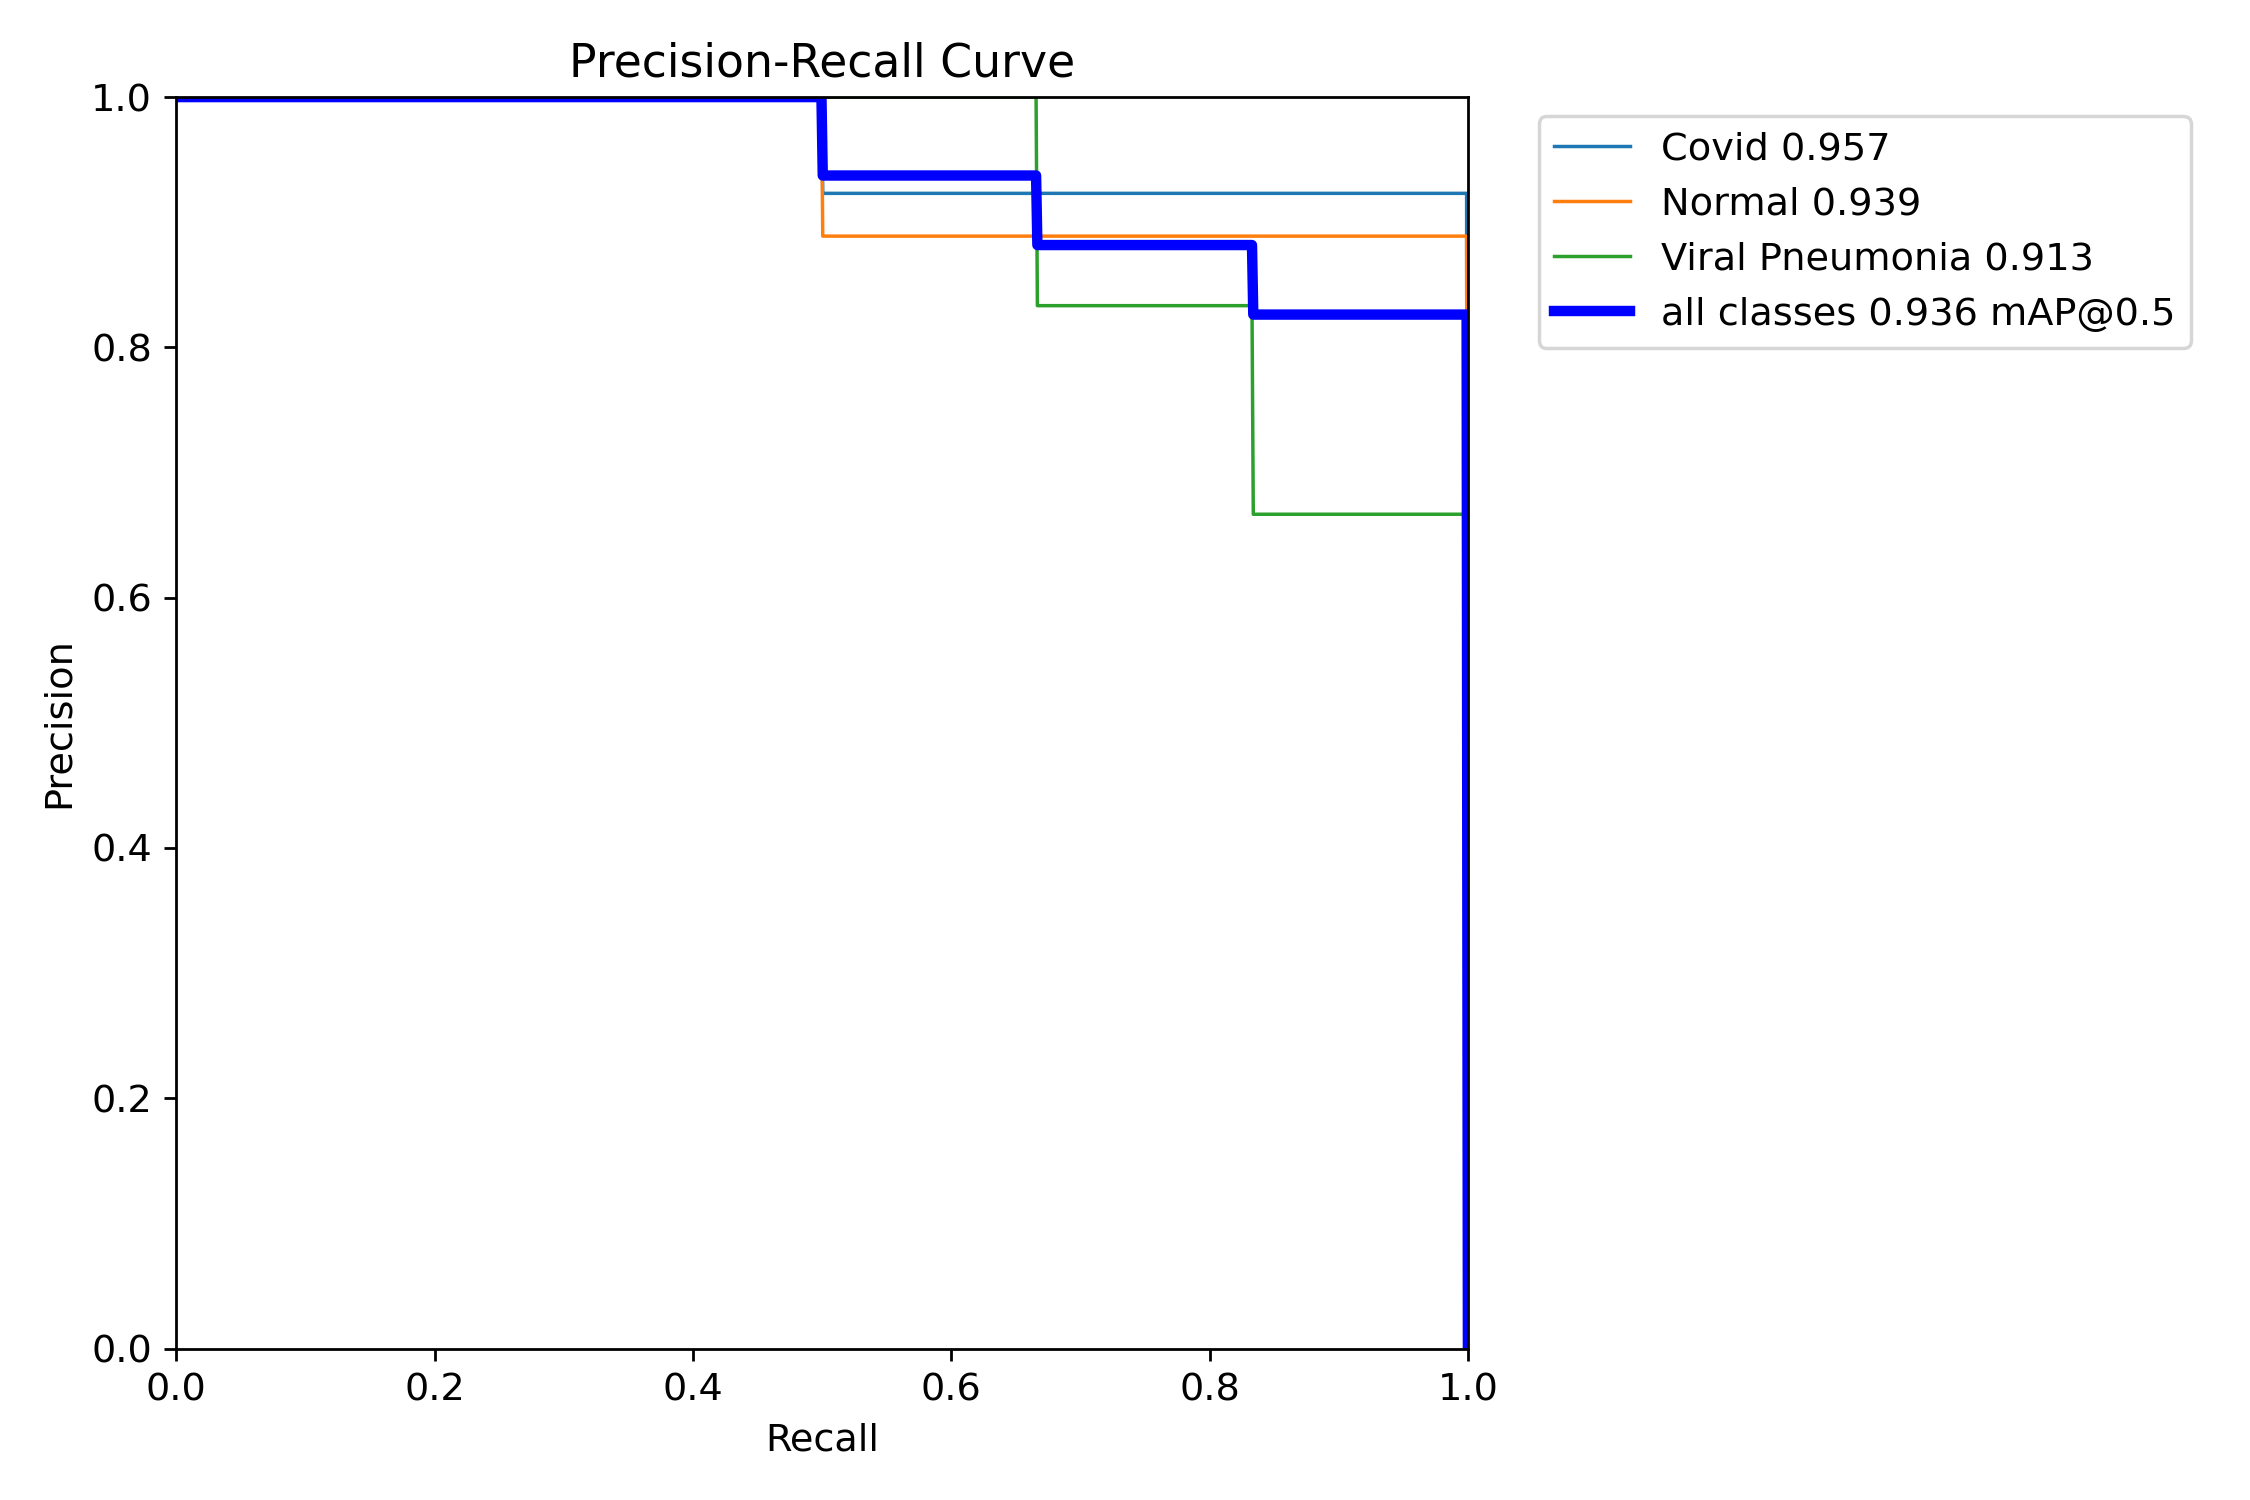

Found PR curve in /content/runs/detect/train


In [ ]:
# find the latest training directory
train_dirs = sorted(glob.glob(f"{HOME}/runs/detect/train"), key=os.path.getmtime, reverse=True)
val_results_dir = None

# look for my man PR_curve.png
if train_dirs:
    for train_dir in train_dirs:
        if os.path.exists(os.path.join(train_dir, "PR_curve.png")):
            val_results_dir = train_dir
            break

# Plot precision-recall curve
if val_results_dir:
    pr_curve_path = os.path.join(val_results_dir, "PR_curve.png")
    if os.path.exists(pr_curve_path):
        display(IPyImage(filename=pr_curve_path, width=800))
        print(f"Found PR curve in {val_results_dir}")
    else:
        print(f"PR curve not found in {val_results_dir}")
else:
    print("Could not find validation results in any training directory")

### Create a bar chart comparing class-wise metrics

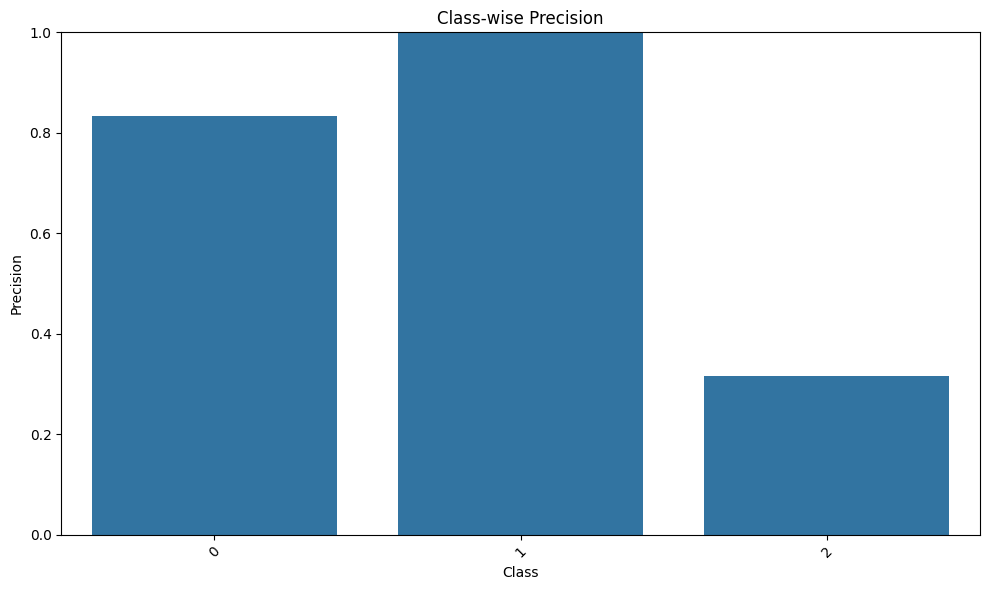

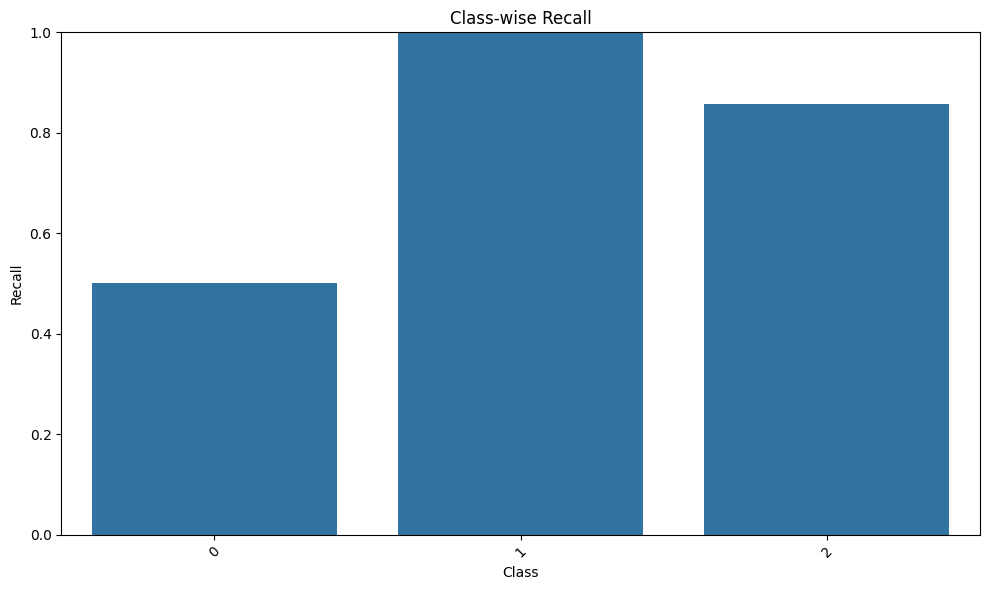

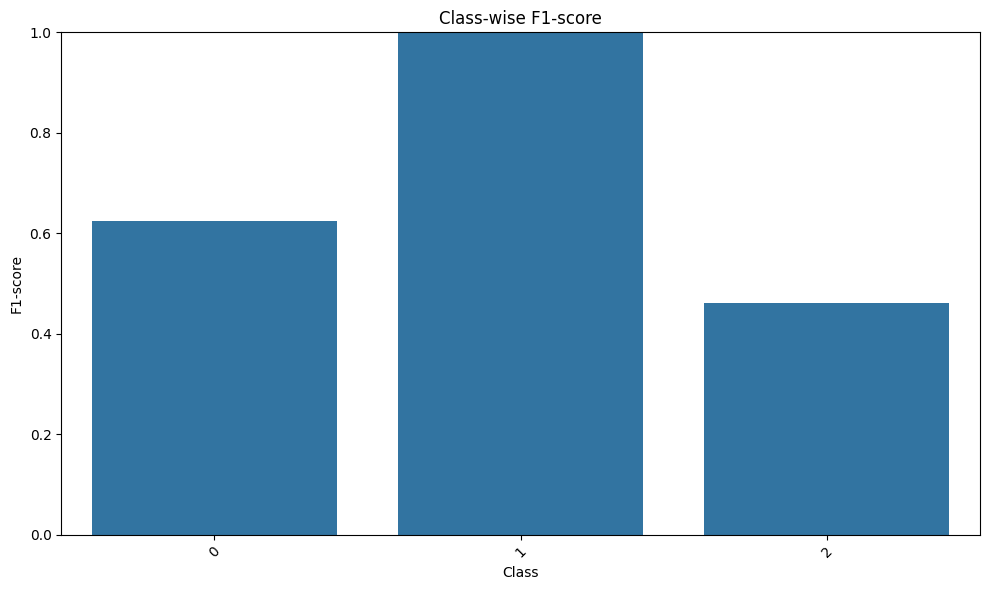

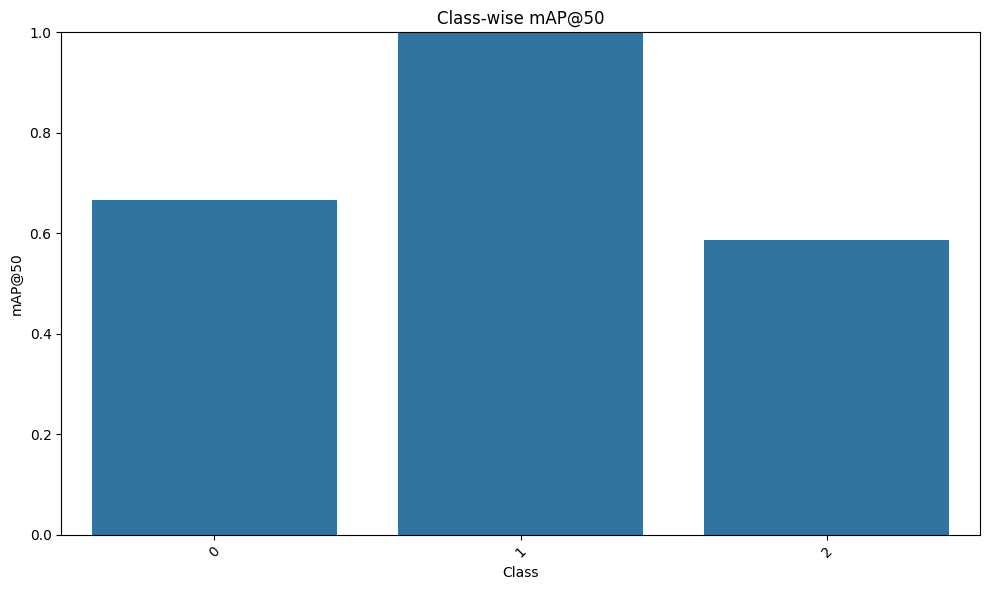

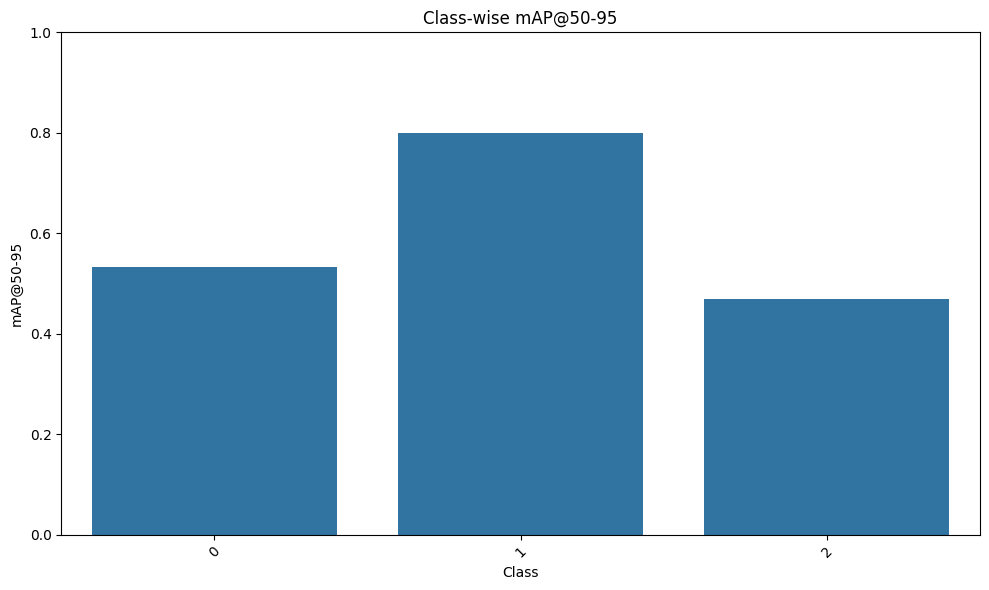

In [ ]:
# Create a bar chart comparing class-wise metrics
def plot_class_metrics(df, metric_name):
    if df is None or len(df) == 0 or 'Class' not in df.columns:
        print(f"No valid class metrics data for {metric_name}")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y=metric_name, data=df)
    plt.title(f'Class-wise {metric_name}')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Make sure class_metrics_df exists and has data
if 'class_metrics' in globals() and len(class_metrics) > 0:
    # Create a DataFrame if it's just a list of dictionaries
    if not isinstance(class_metrics_df, pd.DataFrame):
        class_metrics_df = pd.DataFrame(class_metrics)

    # Plot each metric
    for metric in ['Precision', 'Recall', 'F1-score', 'mAP@50', 'mAP@50-95']:
        if metric in class_metrics_df.columns:
            plot_class_metrics(class_metrics_df, metric)
elif 'class_metrics_df' in globals() and isinstance(class_metrics_df, pd.DataFrame) and len(class_metrics_df) > 0:
    # Plot each metric
    for metric in ['Precision', 'Recall', 'F1-score', 'mAP@50', 'mAP@50-95']:
        if metric in class_metrics_df.columns:
            plot_class_metrics(class_metrics_df, metric)
else:
    print("No valid class metrics data available")


## Create a radar chart for overall metrics comparison

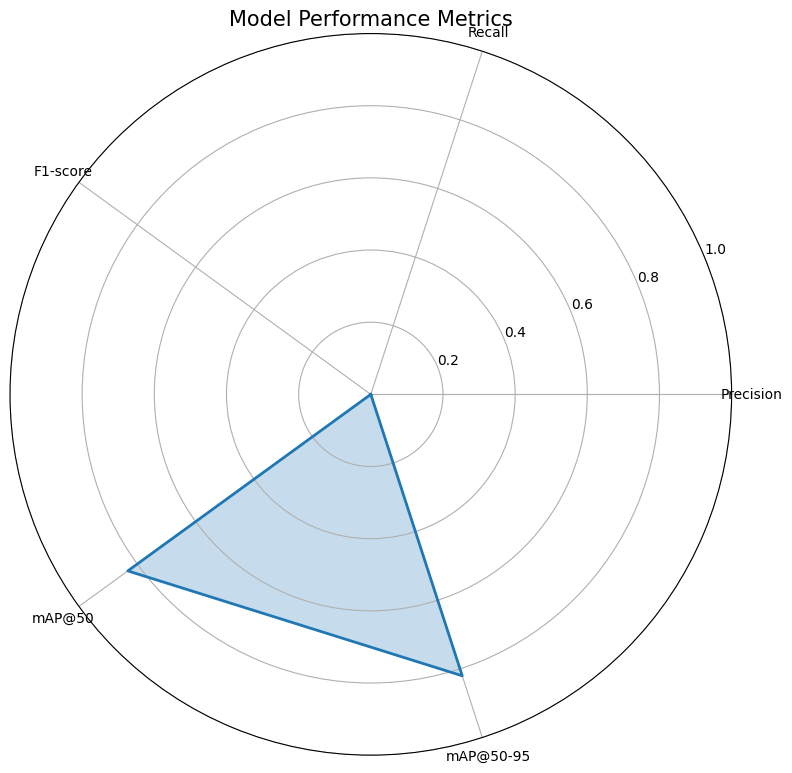

In [ ]:
def plot_radar_chart(metrics_dict):
    categories = ['Precision', 'Recall', 'F1-score', 'mAP@50', 'mAP@50-95']
    values = []

    # Extract simple float values from the metrics dictionary
    for cat in categories:
        if cat in metrics_dict:
            try:
                # Try different approaches to extract a scalar value
                val = metrics_dict[cat]
                if hasattr(val, 'item'):  # PyTorch tensor
                    try:
                        values.append(float(val.item()))
                    except (ValueError, TypeError):
                        values.append(0.0)
                elif hasattr(val, 'tolist'):  # Numpy array
                    try:
                        arr = val.tolist()
                        if isinstance(arr, (list, tuple)):
                            values.append(float(arr[0]))
                        else:
                            values.append(float(arr))
                    except (ValueError, TypeError, IndexError):
                        values.append(0.0)
                else:
                    values.append(float(val))
            except (ValueError, TypeError):
                print(f"Could not convert {cat} value to float")
                values.append(0.0)
        else:
            values.append(0.0)

    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    values = values + [values[0]]  # Close the plot
    angles = angles + [angles[0]]  # Close the plot
    categories = categories + [categories[0]]  # Close the plot

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.set_title("Model Performance Metrics", size=15)
    plt.tight_layout()
    plt.show()

# Create a simple dictionary with just scalar values for the radar chart
scalar_metrics = {}
try:
    if 'metrics' in globals() and isinstance(metrics, dict):
        for key, val in metrics.items():
            try:
                if hasattr(val, 'item'):
                    scalar_metrics[key] = val.item()
                elif hasattr(val, 'tolist'):
                    arr = val.tolist()
                    if isinstance(arr, (list, tuple)):
                        scalar_metrics[key] = float(arr[0])
                    else:
                        scalar_metrics[key] = float(arr)
                else:
                    scalar_metrics[key] = float(val)
            except (ValueError, TypeError):
                # Skip values that can't be converted to float
                continue

        if scalar_metrics:
            plot_radar_chart(scalar_metrics)
        else:
            print("Could not extract scalar values for radar chart")
    else:
        print("No valid metrics dictionary available")
except Exception as e:
    print(f"Error creating radar chart: {str(e)}")


## Visualize FPS performance

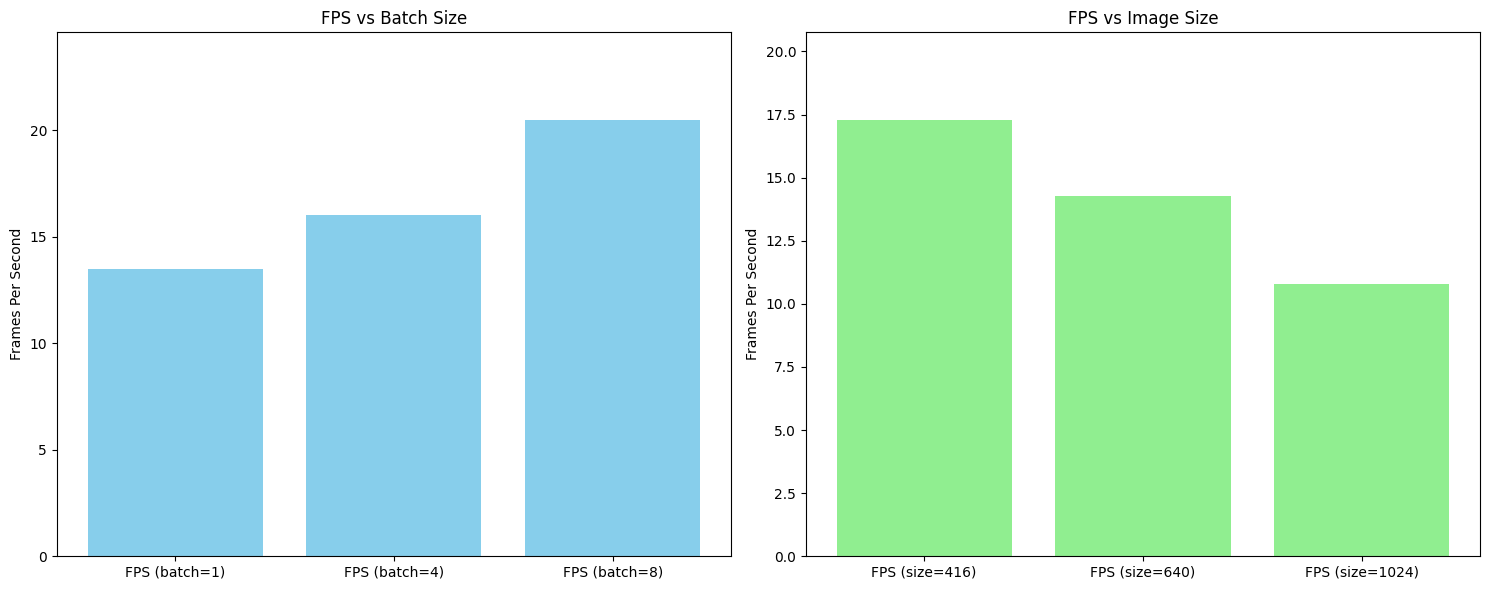

In [ ]:
def plot_fps_comparison():
    # Check if fps metrics are available
    if 'fps_metrics' not in globals() or not fps_metrics or 'img_size_fps' not in globals() or not img_size_fps:
        print("FPS metrics not available")
        return

    batch_sizes = list(fps_metrics.keys())
    batch_fps = list(fps_metrics.values())

    img_sizes = list(img_size_fps.keys())
    img_fps = list(img_size_fps.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.bar(batch_sizes, batch_fps, color='skyblue')
    ax1.set_title('FPS vs Batch Size')
    ax1.set_ylabel('Frames Per Second')
    if batch_fps:
        ax1.set_ylim(0, max(batch_fps) * 1.2)

    ax2.bar(img_sizes, img_fps, color='lightgreen')
    ax2.set_title('FPS vs Image Size')
    ax2.set_ylabel('Frames Per Second')
    if img_fps:
        ax2.set_ylim(0, max(img_fps) * 1.2)

    plt.tight_layout()
    plt.show()

# Plot FPS comparison if metrics are available
if ('fps_metrics' in globals() and isinstance(fps_metrics, dict) and
    'img_size_fps' in globals() and isinstance(img_size_fps, dict)):
    plot_fps_comparison()
else:
    print("FPS metrics not available or in incorrect format")

## Visualize predictions on test images


image 1/1 /content/datasets/covid19_yolo/test/images/0103.jpeg: 480x640 1 Viral Pneumonia, 30.7ms
Speed: 8.0ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


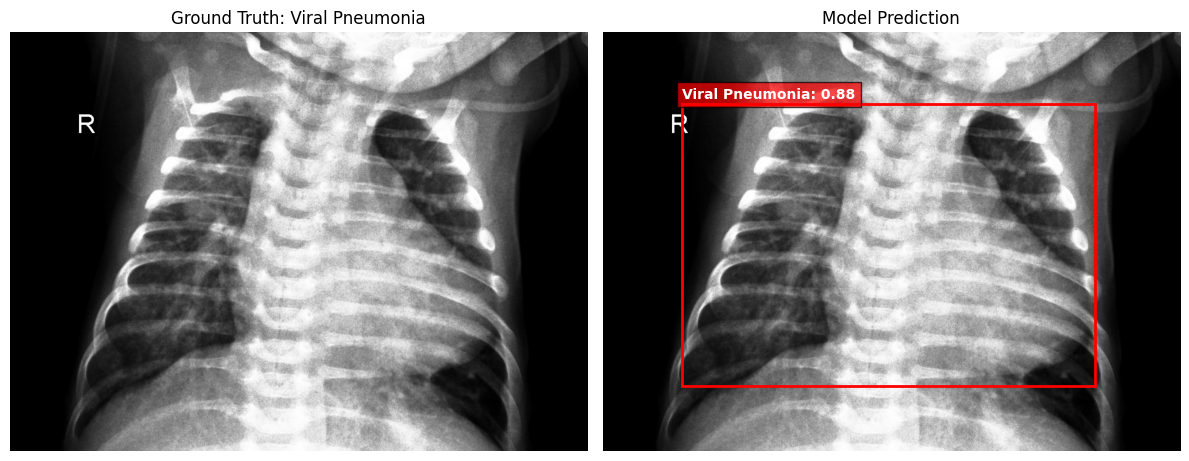


image 1/1 /content/datasets/covid19_yolo/test/images/0112.jpeg: 544x640 1 Normal, 1 Viral Pneumonia, 37.3ms
Speed: 4.6ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


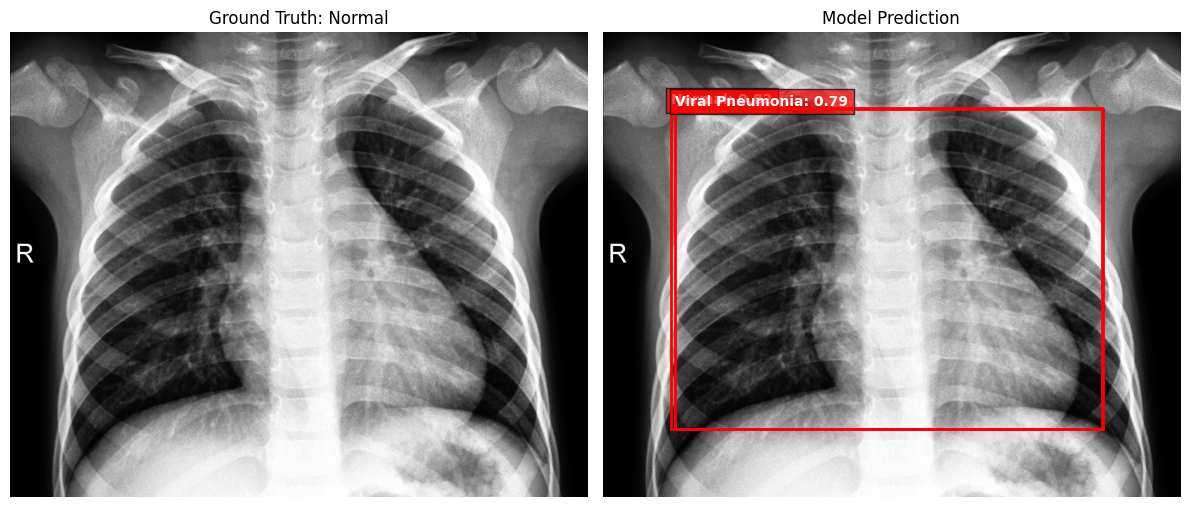


image 1/1 /content/datasets/covid19_yolo/test/images/0120.jpeg: 448x640 1 Viral Pneumonia, 29.5ms
Speed: 4.4ms preprocess, 29.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


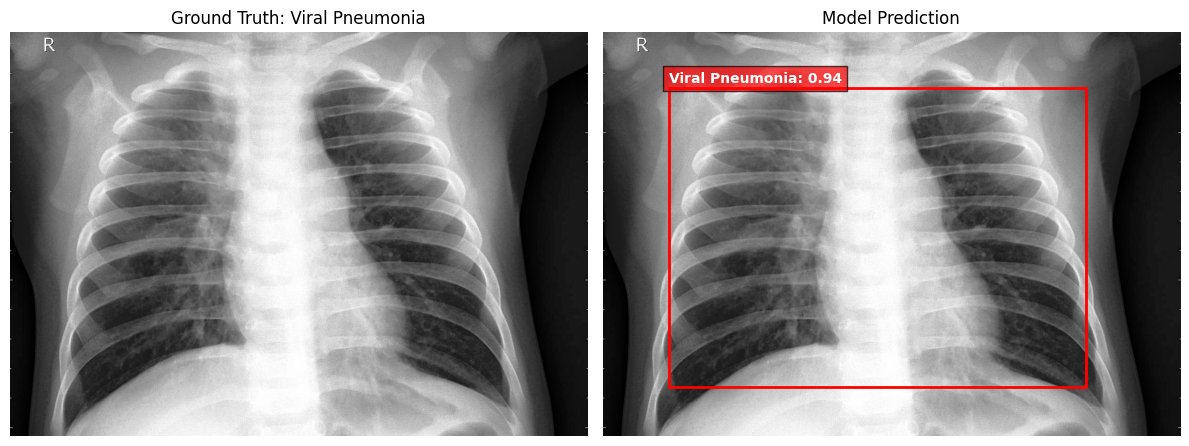

In [ ]:
def visualize_predictions(model, num_samples=3):
    # Check if test images directory exists
    test_images_dir = f"{HOME}/datasets/covid19_yolo/test/images"
    if not os.path.exists(test_images_dir):
        print(f"Test images directory not found: {test_images_dir}")
        return

    test_images = glob.glob(f"{test_images_dir}/*")
    if not test_images:
        print("No test images found")
        return

    # Sample a few images
    samples = random.sample(test_images, min(num_samples, len(test_images)))

    for img_path in samples:
        try:
            # Run prediction
            results = model.predict(img_path, conf=0.25, imgsz=img_size)[0]

            # Load and convert image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get ground truth label
            img_name = os.path.basename(img_path)
            label_path = os.path.join(
                f"{HOME}/datasets/covid19_yolo/test/labels",
                os.path.splitext(img_name)[0] + '.txt'
            )

            gt_class_name = "Unknown"
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    line = f.readline().strip()
                    parts = line.split()
                    if parts:
                        try:
                            gt_class_id = int(float(parts[0]))
                            if gt_class_id < len(class_mapping):
                                gt_class_name = list(class_mapping.keys())[gt_class_id]
                        except (ValueError, IndexError):
                            pass

            # Create visualization
            plt.figure(figsize=(12, 8))

            # Ground truth
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Ground Truth: {gt_class_name}")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 2, 2)
            plt.imshow(img)

            # Add bounding boxes and labels if available
            if hasattr(results, 'boxes') and len(results.boxes) > 0:
                try:
                    boxes = results.boxes.xyxy.cpu().numpy()
                    conf = results.boxes.conf.cpu().numpy()
                    cls = results.boxes.cls.cpu().numpy().astype(int)

                    for box, conf_val, cls_id in zip(boxes, conf, cls):
                        if cls_id < len(class_mapping):
                            x1, y1, x2, y2 = box.astype(int)
                            class_name = list(class_mapping.keys())[cls_id]
                            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                fill=False, edgecolor='red', linewidth=2))
                            plt.text(x1, y1-10, f"{class_name}: {conf_val:.2f}",
                                    color='white', fontweight='bold',
                                    bbox=dict(facecolor='red', alpha=0.7))
                except Exception as e:
                    print(f"Error drawing boxes: {str(e)}")

            plt.title("Model Prediction")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")

# Try to visualize predictions if model is available
if 'model' in globals():
    try:
        visualize_predictions(model, num_samples=3)
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
else:
    print("Model variable not found. Skipping prediction visualization.")